# American Sign Language (ASL) Dataset


In [ ]:
!pip install jovian --upgrade --quiet

In [ ]:
import jovian

In [ ]:
# Execute this to save new versions of the notebook
jovian.commit(project="ASL-course-project")

[jovian] Detected Colab notebook...
[jovian] Please enter your API key ( from https://jovian.ai/ ):
API KEY: ··········
[jovian] Uploading colab notebook to Jovian...
Committed successfully! https://jovian.ai/deep3700/asl-course-project


'https://jovian.ai/deep3700/asl-course-project'

#Introduction

This dataset is the collection of images of alphabets gestures from the American Sign Language that serves as a sign language of Deaf communities around the world.



Import Python Library opendatasets to download the Kaggle Dataset from Url.

In [ ]:
!pip install opendatasets --upgrade --quiet
import opendatasets as od

In [ ]:
dataset_url = 'https://www.kaggle.com/datasets/grassknoted/asl-alphabet'

In [ ]:
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: casimirknight
Your Kaggle Key: ··········


100%|██████████| 1.03G/1.03G [00:33<00:00, 32.9MB/s]


# Information about the data and files



*   **Train** - Contains all the images that will be used for Training and validation of the model. The Training dataset contains 87,000 images which are 200 x 200. There are 29 Classes of which 26 are alphabets from A-Z and 3 classes for SPACE, DELETE, NOTHING.
*   **Test** - The test data set contains a mere 29 images, to encourage the use of real-world test images.




Import the rest of the PyTorch Libraries

In [ ]:
import os
import torch
import pandas as pd
import numpy as np
import torchvision
import tarfile
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as tt
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#Exploraing the Data

In [ ]:
data_dir = '/content/asl-alphabet'
print(os.listdir(data_dir))
classes = os.listdir(data_dir + '/asl_alphabet_train/asl_alphabet_train') 
print(classes)


['asl_alphabet_train', 'asl_alphabet_test']
['nothing', 'I', 'O', 'P', 'M', 'U', 'H', 'T', 'J', 'A', 'del', 'D', 'Q', 'K', 'G', 'Y', 'B', 'W', 'S', 'C', 'R', 'L', 'N', 'Z', 'space', 'E', 'V', 'X', 'F']


We have found that there are total 29 types of images within folder asl_alphabet_train and we will be attempting to predict these with our deep learning model

Let's count the number of images of each class have.

In [ ]:
num_count = []
for x in classes:
  num = len(os.listdir(data_dir + '/asl_alphabet_train/asl_alphabet_train/' + x ))
  num_count.append(num)
  print(x + " Class has "+ str(num)+" Number of Images.")
print(' There are Total '+ str(sum(num_count))+ ' Number of Images ')

nothing Class has 3000 Number of Images.
I Class has 3000 Number of Images.
O Class has 3000 Number of Images.
P Class has 3000 Number of Images.
M Class has 3000 Number of Images.
U Class has 3000 Number of Images.
H Class has 3000 Number of Images.
T Class has 3000 Number of Images.
J Class has 3000 Number of Images.
A Class has 3000 Number of Images.
del Class has 3000 Number of Images.
D Class has 3000 Number of Images.
Q Class has 3000 Number of Images.
K Class has 3000 Number of Images.
G Class has 3000 Number of Images.
Y Class has 3000 Number of Images.
B Class has 3000 Number of Images.
W Class has 3000 Number of Images.
S Class has 3000 Number of Images.
C Class has 3000 Number of Images.
R Class has 3000 Number of Images.
L Class has 3000 Number of Images.
N Class has 3000 Number of Images.
Z Class has 3000 Number of Images.
space Class has 3000 Number of Images.
E Class has 3000 Number of Images.
V Class has 3000 Number of Images.
X Class has 3000 Number of Images.
F Class 

87,000 number of images are seperated evenly throughoutthe 29 Classes.Containing 3000 each.

Let's view the images and rest of details.

In [ ]:
training_set = ImageFolder(data_dir + '/asl_alphabet_train/asl_alphabet_train', transform = tt.ToTensor())

In [ ]:
def show_img(img , lable):
  print('Lable: '+ training_set.classes[lable] + '('+str(lable)+')' )
  plt.imshow(img.permute(1,2,0))


Lable: A(0)


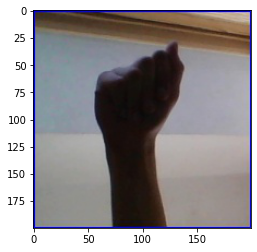

In [ ]:
show_img(*training_set[0])

Lable: C(2)


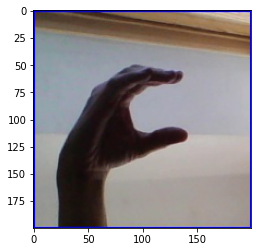

In [ ]:
show_img(*training_set[7000])

Lable: D(3)


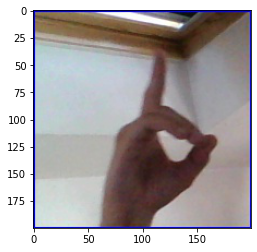

In [ ]:
show_img(*training_set[9876])

Lable: I(8)


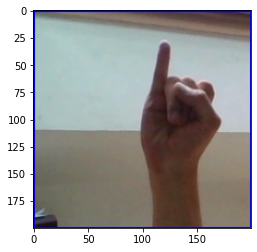

In [ ]:
show_img(*training_set[26756])

Lable: space(28)


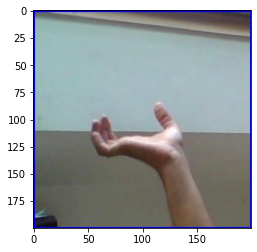

In [ ]:
show_img(*training_set[86999])

# Training and Validation Datasets


As there is no validation dataset, We'll have to split the train dataset to train dataset and validation dataset. This can be done with the help of split-folders which split the contents into given ratios.

In [ ]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
val_ratio = 0.2  # 80 % of Training Dataset and 20 % of validation Dataset.  

In [ ]:
img_dir = '/content/asl-alphabet/asl_alphabet_train/asl_alphabet_train'

In [ ]:
import splitfolders
splitfolders.ratio(img_dir, output="/content/asl-alphabet/asl_alphabet_data", seed=1337, ratio=(1-val_ratio , val_ratio))

Copying files: 87000 files [00:14, 5984.96 files/s]


#Data Prepration
Now, Let's prepaire the data for training the model we will be using Normalization, Data Augmentation.



*   **Channel-wise data normalization** - Image normalization means image tensors will normalize by substracting the mean and then dividing by the Standard Devation and this is performend accross all the channels. This will help prevent pixel values from any one channel from affecting the losses and gradients. 
*   **Data Augmentation** - Augmentation can be any where from increating the brightness, horizontally flipping the image, or adding pad of 4pixel to each randomly selected images. This will help model to generalize rather than learing specific patters in the images. 



In [ ]:
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
train_tfms = tt.Compose([tt.Resize((100,100)),
                         #tt.RandomCrop(200, padding=4, padding_mode='reflect'), 
                         tt.RandomHorizontalFlip(), 
                         #tt.RandomRotation(10),
                         tt.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                         tt.ToTensor(), 
                         tt.Normalize(*stats,inplace=True)])
valid_tfms = tt.Compose([tt.Resize((100,100)),tt.ToTensor(), tt.Normalize(*stats)])

In [ ]:
# Creating an Imagefolder with the new transformation for each dataset
train_ds = ImageFolder(data_dir + '/asl_alphabet_data/train' , transform = train_tfms)
val_ds = ImageFolder(data_dir + '/asl_alphabet_data/val' , transform = valid_tfms)

In [ ]:
train_ds , val_ds

(Dataset ImageFolder
     Number of datapoints: 69600
     Root location: /content/asl-alphabet/asl_alphabet_data/train
     StandardTransform
 Transform: Compose(
                Resize(size=(100, 100), interpolation=bilinear, max_size=None, antialias=None)
                RandomHorizontalFlip(p=0.5)
                ColorJitter(brightness=[0.9, 1.1], contrast=[0.9, 1.1], saturation=[0.9, 1.1], hue=[-0.1, 0.1])
                ToTensor()
                Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
            ), Dataset ImageFolder
     Number of datapoints: 17400
     Root location: /content/asl-alphabet/asl_alphabet_data/val
     StandardTransform
 Transform: Compose(
                Resize(size=(100, 100), interpolation=bilinear, max_size=None, antialias=None)
                ToTensor()
                Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
            ))

In [ ]:
batch_size = 100

In [ ]:
train_dl = DataLoader(train_ds , batch_size , shuffle = True , num_workers = 2 , pin_memory = True )
val_dl = DataLoader(val_ds , batch_size *2 , num_workers = 2 , pin_memory = True)

Let's check the sample images from training dataloader

In [ ]:
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(3, 1, 1)
    stds = torch.tensor(stds).reshape(3, 1, 1)
    return images * stds + means

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
        break

def show_norm_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
        break

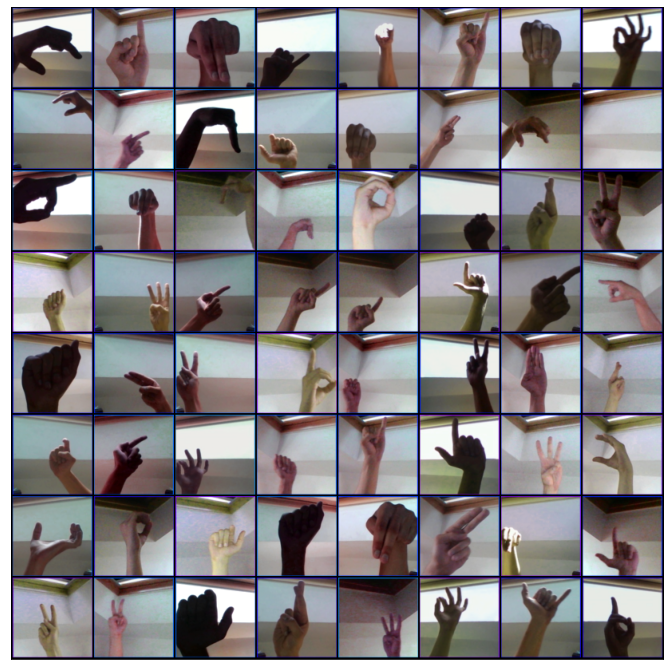

In [ ]:
show_batch(train_dl)

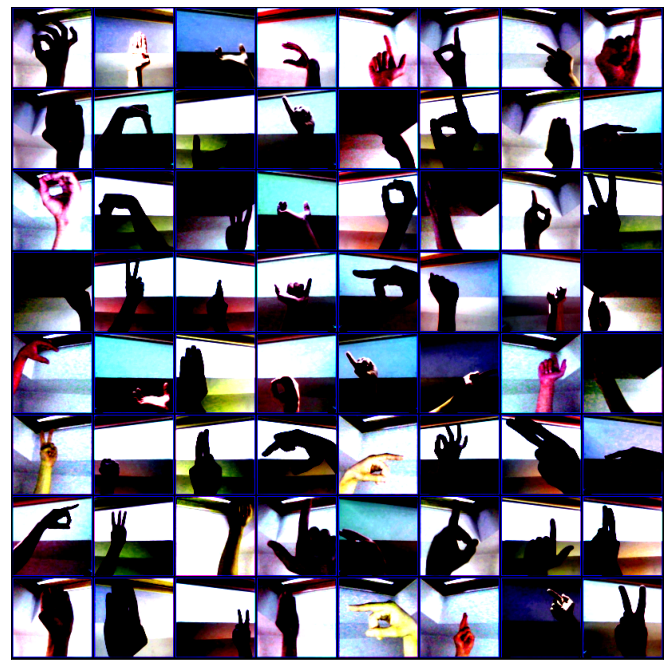

In [ ]:
#Normalized Batch
show_norm_batch(train_dl)

# Using GPU for Processing

We will be using GPU for training the model as using GPU allow the model to do the computations much faster as compaired to CPU. For using GPU in Google Colab make sure Runtime time is changed to GPU.

In [ ]:
def get_default_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

In [ ]:
#to_device moves the data to device 
def to_device(data , device):
  if isinstance(data , (list , tuple)):
    return [to_device(x , device) for x in data]
  return data.to(device , non_blocking = True)


In [ ]:
class DeviceDataLoader():
  def __init__(self , dl , device):
      self.dl = dl
      self.device = device
  def __iter__(self):
    for b in self.dl:
      yield to_device(b , self.device )
  def __len__(self):
    return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

Move datasets to the GPU (cuda).

In [ ]:
train_dl = DeviceDataLoader(train_dl , device)
val_dl = DeviceDataLoader(val_dl ,  device)

# Creating the Model

Our model is going be a Convolutional Neural Network(CNN) with a Residual Neural Network(ResNet) Architecture. The ResNet architecture helps to maintain low error rate much deeper in the network.

## Model


*   **Accuracy** - Accuracy function will calculate the % of correct values.
*   **Training_step** - Training_step function is a steps during training which will calulate loss using *Cross_Entropy* loss function.

* **Validatoin_steps** - This will First generate predictions same as *Training_step* and then Calulate loss and Accuracy of the predictions.

* **Validation_epoch_end** - Calculates the combined loss and accuracy.

* **Epoch_end** - Prints the current Loss and Accuracy.



In [ ]:
def accuracy(outputs , lables):
  _ , preds = torch.max(outputs , dim = 1)
  return torch.tensor(torch.sum(preds == lables).item()/ len(preds))

In [ ]:
class ImageClassificatonBase(nn.Module):
  def training_step( self , batch):
    img , labels = batch
    out = self(img)
    loss = F.cross_entropy(out , labels)
    return loss
  def validation_step(self , batch):
    img , labels = batch
    out  = self(img)
    loss = F.cross_entropy(out , labels)
    acc = accuracy(out , labels)
    return {'val_loss': loss.detach() , 'val_acc': acc} 
  def validation_epoch_end(self , outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()
    batch_acc = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_acc).mean()
    return{'val_loss': epoch_loss.item() ,'val_acc':epoch_acc.item()}
  def epoch_end(self , epoch ,result):
    print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))



This will be architecture of the Neural Network, ```conv_block``` will be the standard network block which will have:
1. ```conv2d``` - Is the convolutional layer.
2. ```BatchNorm2d``` - This will normalize the outputs provided by the Conv2d layer(Prevening losses and gradiants from getting affected).
3. ```Relu``` - Relu is the activation function for the outputs. The function simply changes the negative values in the tensor with ```0``` .
4. ```MaxPool2d``` - Makes the images smaller in Size.

In [ ]:
def conv_block(in_channels , out_channels , pool = False):
  layers = [nn.Conv2d(in_channels , out_channels,  kernel_size = 3 , padding = 1) , 
            nn.BatchNorm2d(out_channels), 
            nn.ReLU(inplace = True)]
  if pool: layers.append(nn.MaxPool2d(2))
  return nn.Sequential(*layers)

In [ ]:
class ResNet_custom(ImageClassificatonBase):
  def __init__(self , in_channels , num_classes):
    super().__init__()

    self.conv1 = conv_block(in_channels , 30)
    self.conv2 = conv_block(30 ,60, pool = True)
    self.res1 = nn.Sequential(conv_block(60 , 60 ) , conv_block(60 , 60))

    self.conv3 = conv_block(60 , 120 , pool = True)
    self.conv4 = conv_block(120 , 240 , pool = True)
    self.res2 = nn.Sequential(conv_block(240 , 240) , conv_block(240 , 240))

    self.conv5 = conv_block(240 , 480 , pool = True)
    self.conv6 = conv_block(480 , 960 , pool = True)
    self.res3 = nn.Sequential(conv_block(960 , 960) , conv_block(960 , 960))

    self.classifier = nn.Sequential(nn.MaxPool2d(3) , 
                                    nn.Flatten(), 
                                    nn.Dropout(0.2), 
                                    nn.Linear(960, 512),
                                    nn.ReLU(),
                                    nn.Linear(512 , num_classes))

  def forward(self, xb): 
    out1 = self.conv1(xb)
    out2 = self.conv2(out1)
    out3 = self.res1(out2) + out2
    
    #out3 from res1

    out4 = self.conv3(out3)
    out5 = self.conv4(out4)
    out6 = self.res2(out5) + out5

    #out6 from res2

    out7 = self.conv5(out6)
    out8 = self.conv6(out7)
    out9 = self.res3(out8) + out8

    out = self.classifier(out9)
    return out


In [ ]:
model = to_device(ResNet_custom(3 , 29), device)
model

ResNet_custom(
  (conv1): Sequential(
    (0): Conv2d(3, 30, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(30, 60, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(60, 60, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(60, 60, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True

In [ ]:
jovian.commit(project = 'ASL-course-project')

# Training the Model



Model during training is using some techniques:

1. Learning Rate Scheduling - We change the learning rate after every batch of training. We increase the learning rate to high learning rate for about 30% o epochs then starts to gradully decrease the learning rate for the remaining epochs.

2. Weight Decay - We use weight decay to prevent the weights becoming large by adding the product of weight decay and the sum of weights^2 to the loss.

3. Gradiant clipping - The idea is simple for gradiant clipping if the gradiants gets too large, we reset it to keep it small. 

In [ ]:
@torch.no_grad()
def evaluate(model , val_loader):
  model.eval() #Evaluation Phase
  outputs = [model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)

In [ ]:
def get_lr(optimizer):
  for param_group in optimizer.param_groups:
    return param_group['lr']

In [ ]:
def fit_one_cycle(epochs , max_lr , model , train_loader , val_loader , weight_decay = 0 , grad_clip = None , opt_func = torch.optim.SGD):
  torch.cuda.empty_cache()
  his = []

  optimizer = opt_func(model.parameters() , max_lr , weight_decay =weight_decay  )

  sched = torch.optim.lr_scheduler.OneCycleLR(optimizer , max_lr , epochs = epochs , steps_per_epoch=len(train_loader) )

  for epoch in range(epochs):
    model.train() #Training Phase

    train_losses = []
    lrs = []

    #Training and computing loss

    for batch in train_loader:
      loss = model.training_step(batch)
      train_losses.append(loss)
      loss.backward()

      #Gradiant Clipping

      if grad_clip:
        nn.utils.clip_grad_value_(model.parameters() , grad_clip)

      #Optimization and recording values
      optimizer.step()
      optimizer.zero_grad()
      lrs.append(get_lr(optimizer))
      sched.step()

    result = evaluate(model, val_loader) # Compute accuracy & loss
    result['train_loss'] = torch.stack(train_losses).mean().item()
    result['lrs'] = lrs 
    model.epoch_end(epoch, result)       # Print results
    his.append(result)
  return his 
    

    


In [ ]:
torch.cuda.empty_cache()

In [ ]:
his = [evaluate(model , val_dl)]
his

[{'val_acc': 0.03448275849223137, 'val_loss': 3.367648124694824}]

In [ ]:
epochs = 10
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4

In [ ]:
%%time
his += fit_one_cycle(epochs , max_lr , model , train_dl , val_dl , weight_decay = weight_decay , grad_clip = grad_clip)

Epoch [0], last_lr: 0.00280, train_loss: 1.1014, val_loss: 0.2439, val_acc: 0.9153
Epoch [1], last_lr: 0.00760, train_loss: 0.0999, val_loss: 0.1156, val_acc: 0.9609
Epoch [2], last_lr: 0.01000, train_loss: 0.0344, val_loss: 0.0092, val_acc: 0.9969
Epoch [3], last_lr: 0.00950, train_loss: 0.0102, val_loss: 0.0004, val_acc: 0.9999
Epoch [4], last_lr: 0.00812, train_loss: 0.0044, val_loss: 0.0005, val_acc: 0.9999
Epoch [5], last_lr: 0.00611, train_loss: 0.0047, val_loss: 0.0001, val_acc: 1.0000
Epoch [6], last_lr: 0.00389, train_loss: 0.0006, val_loss: 0.0000, val_acc: 1.0000
Epoch [7], last_lr: 0.00188, train_loss: 0.0003, val_loss: 0.0000, val_acc: 1.0000
Epoch [8], last_lr: 0.00050, train_loss: 0.0002, val_loss: 0.0000, val_acc: 1.0000
Epoch [9], last_lr: 0.00000, train_loss: 0.0002, val_loss: 0.0000, val_acc: 1.0000
CPU times: user 5min 11s, sys: 1min 37s, total: 6min 48s
Wall time: 34min 46s


In [ ]:
train_time = '34:46'

In [ ]:
def plot_acc(hist):
  acc = [x['val_acc'] for x in hist]
  plt.plot(acc , '-x')
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.title('Accuracy Vs No. of epochs')

In [ ]:
def plot_loss(hist):
  tr_loss = [x.get('train_loss') for x in hist]
  val_loss = [x['val_loss'] for x in hist]
  plt.plot(tr_loss , '-rx')
  plt.plot(val_loss , '-go')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(['Train', 'Validation'])
  plt.title('Loss vs. No. of epochs');

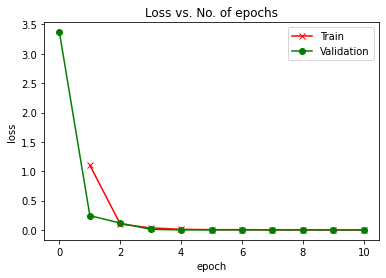

In [ ]:
plot_loss(his)

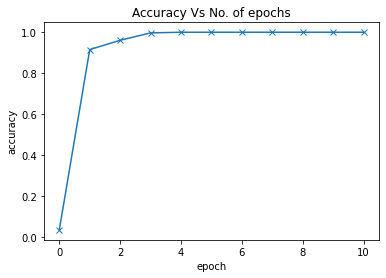

In [ ]:
plot_acc(his)

From 'Accuracy vs No. of epochs' plot we can see that the model reached ~100% of accuracy in the 5 epoch and reached 100% accuracy in 6 epochs.

# Prediction

In [ ]:
# Model Prediction
def predict(im ,model):
  xb = to_device(im.unsqueeze(0) , device)
  yb = model(xb)
  _, preds = torch.max(yb , dim = 1)
  return val_ds.classes[preds[0].item()]

In [ ]:
# Model Prediction and actual label with denomalized images
def model_actual_label(n):
  img , label = val_ds[n]
  plt.imshow(img.permute(1,2,0).clamp(0,1))
  print('Label:', val_ds.classes[label], ', Predicted:', predict(img, model))


Label: A , Predicted: A


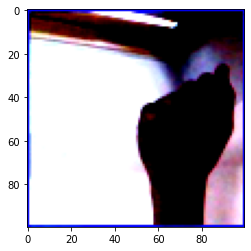

In [ ]:
model_actual_label(1)

Label: B , Predicted: B


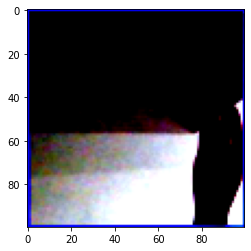

In [ ]:
model_actual_label(897)

Label: T , Predicted: T


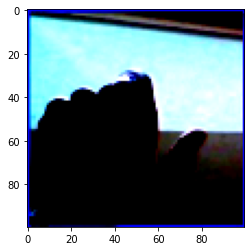

In [ ]:
model_actual_label(11876)

Label: del , Predicted: del


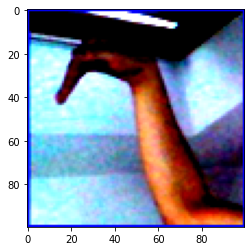

In [ ]:
model_actual_label(15675)

Label: U , Predicted: U


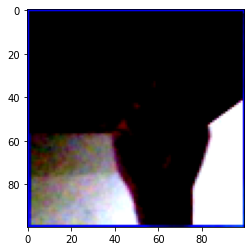

In [ ]:
model_actual_label(12275)

Label: C , Predicted: C


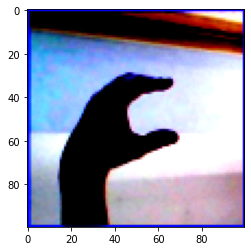

In [ ]:
model_actual_label(1575)

All the images are predicted Correctly.

#Saving the hyperparameters

In [ ]:
torch.save(model.state_dict(), 'ASL-cp.pth')

In [ ]:
jovian.reset()
jovian.log_hyperparams(arch = 'resnet', 
                       epochs = epochs, 
                       lr = max_lr, 
                       scheduler = 'one-cycle', 
                       weight_decay = weight_decay, 
                       grad_clip = grad_clip)

[jovian] Hyperparams logged.


In [ ]:
jovian.log_metrics(val_loss = his[-1]['val_loss'], 
                   val_acc = his[-1]['val_acc'], 
                   train_loss = his[-1]['train_loss'], 
                   time = train_time)

[jovian] Metrics logged.


#Conclusion

We created a Convolutional Neural Network using ResNet Architecture and utilized various ML techiniques to Optimize the learning process. There is a clear example that these techiniques come in handy while working on Deep Learning as we can see in the First Epoch our Accuracy was ~91%. We predicted 28 different types of classes and at the last our model was ~100% accurate. 

But Certainly there is room for improvement.

### Improvements

*   We can try lowering the time to train the model with less epochs as it took around 35 minutes.
*  This model can also be improved by training it on different and more sign language.
* We can also try to train the model on the dataset of full body rather just the hand.




In [ ]:
jovian.commit(project = 'ASL-course-project')

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
Committed successfully! https://jovian.ai/deep3700/asl-course-project


'https://jovian.ai/deep3700/asl-course-project'